In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from IPython.display import HTML

# ffmpeg -framerate 60 -i "plot%d.jpg" -c:v libx264 -pix_fmt yuv420p output.mp4

In [2]:
fig = plt.figure()

C = {
    'G' : 1, #6.67e-11 meters, kg, seconds
    'dT' : 1,
    'eT' : 0,
    'tLim' : 3000,
    'km' : 1000
}


<Figure size 432x288 with 0 Axes>

In [3]:
aList = [] #active
dList = [] #disabled

def cullList():
    temp = []
    for a in aList:
        if a.active == True:
            temp.append(a)
        else:
            dList.append(a)
    aList.clear()
    for a in temp:
        aList.append(a)

In [4]:
m_list = [1.9884e30, 5.972e24 ]

r_list = [696342, 40030]

In [6]:
global G, dT, scale

scale = 1e-4
G = 6.672e-11*scale**2
dT = 10

class Particle:
    
    def __init__(self,id = 0, r = np.zeros(2), v = np.zeros(2), R = 1e5, m = 1e2 , color = 'blue'):
        "r = Ortsvektor, v = Geschwindigkeitsvektor, R = Radius , m = Masse, color = Farbe"
        self.id = id
        self.r = r
        self.v = v
        self.R = R
        self.m = m 
        self.color = color


    def calc_Force(self, particle_list, dT):
        fG = 0
        for entry in particle_list:
            
            # check if it is not the same particle
            if entry != self:
                dist = np.linalg.norm(self.r - entry.r) + np.finfo(float).eps
                
                if dist > (self.R + entry.R) * dT:
                    # gravitational force 
                    fG -= (G * (self.m * entry.m) / dist**3) * (self.r - entry.r)
                    #sig = 3.4 
                    #eps = 1.67
                    #fLJP = 24.*eps * ((2*(sig/dist)**13) - (sig/dist)**7) * (self.r - entry.r)
                    
        return fG

    
    
    def calc_velocity(self, particle_list, dT=dT):
        force = self.calc_Force(particle_list, dT=dT)
        self.v = np.add(self.v, (force / self.m) * dT, dtype='float64')

        
    def calc_coord(self, dT=dT):
        try:
            self.r += self.v * dT
        except:
            print(self.r, self.v, dT)
        
        
    def print_particle(self):
        print('r: ' , self.r)
        print('v: ' ,self.v)
        print('m: ', self.m)
        print('R: ', self.R)
        
        

$V = \frac{m}{\rho}$ and $ V = \frac{4}{3} \pi R^3$ --> $\frac{4}{3} \pi R^3 = \frac{m}{\rho}$

$R = \left ( \frac{3 \pi m}{4 \rho} \right)^{\frac{1}{3}}$

In [7]:
class Simulation:
    X = 150e6 * scale
    Y = 150e6 * scale
    
    def __init__(self, Np=5, dT=1):
        'Np = Number Particles, dT = Timestep'
        
        # particle parameters
        m_list = np.array([1.9884e30, 5.972e24 ]) * scale
        r_list = np.array([[0,0], [-40000., 10e2]]) 
        R_list = np.array([696342, 40030]) * scale
        #m_list = np.random.randint(1, 10, size=(Np))*5e2 
        #r_list = np.random.uniform(-200, 200, size=(Np,2))
        v_list = np.array([[0.,0.], [30.,+35.]])
        #v_list = np.random.uniform(100, 500, size=(Np,2))
        #R_list = (3*np.pi * m_list /4)**(1/3)
        
        
        self.particles = [Particle(i, r=r_list[i], v=v_list[i], R=R_list[i], m=m_list[i]) for i in range(Np)]
        
        
    def increment(self):
        for particle in self.particles:
            particle.calc_velocity(self.particles)
            particle.calc_coord()
            
        
    def particle_positions(self):
        return np.array([particle.r for particle in self.particles])
    
    def masses_for_size(self):
        return np.array([particle.m for particle in self.particles])
    
    def particle_colors(self):
        return [particle.color for particle in self.particles]
    
    def Radius_for_size(self):
        return np.array([particle.R for particle in self.particles]) 

In [8]:
Sim = Simulation(2,dT)

In [9]:
for particle in Sim.particles:
    print(particle.r)

[0. 0.]
[-40000.   1000.]


In [10]:
Sim.Radius_for_size()

array([69.6342,  4.003 ])

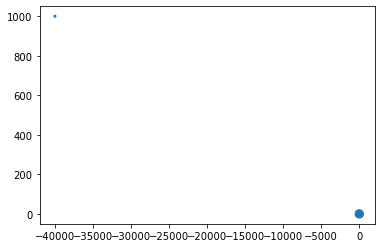

In [11]:
t = Sim.particle_positions()
plt.scatter(t[:,0], t[:,1], s=Sim.Radius_for_size())

In [12]:
def init():
    ax.set_xlim(-Sim.X, Sim.X)
    ax.set_ylim(-Sim.Y, Sim.Y)

    positions = Sim.particle_positions()
    colors = Sim.particle_colors()
    sizes = Sim.masses_for_size()
    scatter = ax.scatter(positions[:,0], positions[:,1], c=colors, s=sizes)

    return [scatter]

def update(frame):
    Sim.increment()
    
    
    scatter.set_offsets(np.array(Sim.particle_positions()))
    scatter.set_color(Sim.particle_colors())
    #scatter.set_sizes(['blue' for ind, part in enumerate(Sim.particle_positions())])
    return [scatter]

# Visualizing the Simulation

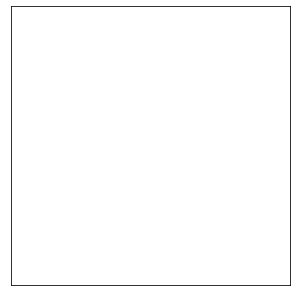

In [14]:
fig, ax = plt.subplots(figsize = (5,9))

ax.set_xticks([]), ax.set_yticks([])
ax.set_aspect('equal')
scatter = ax.scatter([],[])

In [15]:
#  blit = True, 
anim = FuncAnimation(fig, update, frames = range(30*2), init_func = init,interval = 1/30, repeat = False, blit=True)

plt.show()

## Built-in way (slow)
The cells below are not marked as code as it takes a long time to run. A quicker way is found in the next section where ffmpeg is used in the command line to stick together a video out of images.

## Prepare for ffmpeg in command line

In [ ]:
def pick_apart(coord_list):
    coord_list = np.array(coord_list)
    lst = coord_list.reshape(-1, 2).tolist()
    first_entries = lst[::2]
    rest_of_sublists = lst[1::2]
    
    return first_entries, rest_of_sublists

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(-Sim.X*2, Sim.X*2)
ax.set_ylim(-Sim.Y*2, Sim.Y*2)
ax.set_xticks([]), ax.set_yticks([])
#ax.set_aspect('equal')
coords = Sim.particle_positions()
ax.scatter(coords[:,0], coords[:,1], s=Sim.Radius_for_size())
plt.savefig(f'./Test/plot{0}.jpg')
coord_plot = list()

ges = 100
for step in range(ges):
    ax.clear()
    coords = Sim.particle_positions()
    ax.scatter(coords[0,0], coords[0,1], s=Sim.Radius_for_size()[0]*2, c='blue')
    
    ax.set_xlim(-Sim.X*2, Sim.X*2)
    ax.set_ylim(-Sim.Y*2, Sim.Y*2)
    ax.set_xticks([]), ax.set_yticks([])
    Sim.increment()
    coord_plot.append(Sim.particle_positions())
    
    n1, n2 = pick_apart(coord_plot)
    n1 = np.array(n1)
    n2 = np.array(n2)
    ax.plot(n1[:,0],n1[:,1], linestyle='--', label='n1', linewidth=50)
    ax.plot(n2[:,0],n2[:,1], linestyle='--', label='n2')
    
    plt.savefig(f'./Test/plot{step+1}.jpg')
    
    
coords = Sim.particle_positions()
ax.scatter(coords[:,0], coords[:,1], s=Sim.Radius_for_size()*2, c='black')
plt.savefig(f'./Test/plot{ges+1}.jpg')


# Create Video
When having ffmpeg installed one can use that command line below to create the animation.
This was implemented as matplotlib was taking a lot of time. 
```console
ffmpeg -framerate 60 -i "plot%d.jpg" -c:v libx264 -pix_fmt yuv420p output.mp4 ```